<a href="https://colab.research.google.com/github/sai-2005-ai/Student_Study_Assistant/blob/main/Study_Assistent_Final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device set to use cpu
No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Saving technology_benefits.pdf to technology_benefits.pdf
✅ File uploaded: technology_benefits.pdf

✅ PDF text extracted.



Your max_length is set to 142, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


📝 Summary:
🔹 1. Technology has revolutionized the way we live, work, and communicate. With the rise of smartphones and the internet, staying connected with friends and family has never been easier. Healthcare has seen significant improvements due to technology. Automation, data analysis, and digital communication streamline operations and enable global collaboration.

🔹 2. Electric vehicles, high-speed trains, and ride-sharing apps are transforming the way we travel. Smart home devices improve quality of life by offering convenience and energy efficiency. Online shopping and digital payments provide convenience and security. Streaming platforms, virtual reality, and gaming offer immersive experiences for users of all ages.

🔑 Key Points:
  • Technology has revolutionized the way we live, work, and communicate.
  • With the rise of smartphones and the internet, staying connected with friends and family has never been easier.
  • Healthcare has seen significant improvements due to techno

/tmp/ipython-input-5-1725379176.py:156: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


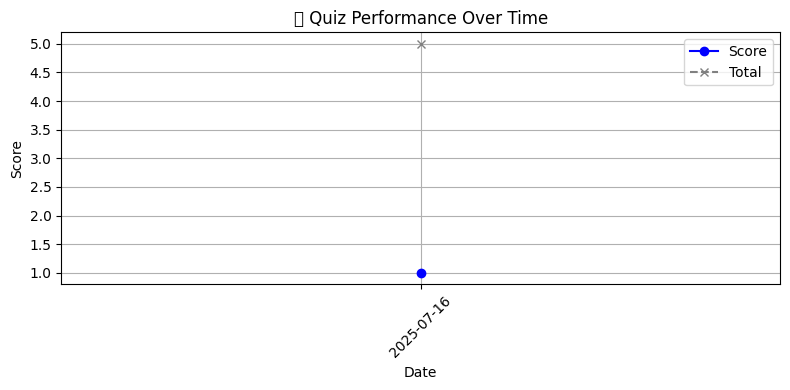


📚 Question & Answer Pairs:
1. Q: What is the main topic of technology that has improved access to information?
   A: Education.

2. Q: What has improved access to information?
   A: Education.

3. Q: What has been the biggest improvement in healthcare?
   A: Technology.

4. Q: What have brought people closer regardless of distance?
   A: Video calls, messaging apps, and social media.

5. Q: What is the reason technology is saving lives?
   A: Advanced diagnostic tools, telemedicine, and robotic surgeries.


🎯 Ask Questions from Your Study Notes
🔎 Your Question (or type 'exit'): exit
📈 Plotting your daily study summary progress...



/tmp/ipython-input-5-1725379176.py:127: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


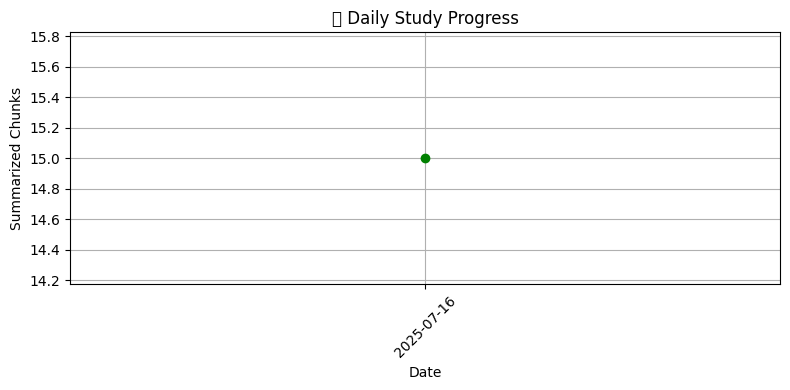

In [5]:
!pip install pdfplumber matplotlib transformers

import pdfplumber, os, datetime, json, random
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer, T5ForConditionalGeneration

# --- Load Models ---
# ✅ BART for Text Summarization
# Model: facebook/bart-large-cnn (Pretrained on CNN/DailyMail)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
# ✅ BERT for Question Answering
# Model: bert-large-uncased-whole-word-masking-finetuned-squad
qa_pipeline = pipeline("question-answering")
#✅ T5 for Question Generation (QG & QA pairs)
# Model: valhalla/t5-small-qg-prepend
qg_tokenizer = AutoTokenizer.from_pretrained("valhalla/t5-small-qg-prepend")
qg_model = T5ForConditionalGeneration.from_pretrained("valhalla/t5-small-qg-prepend")

progress_file = "study_progress.json"
score_file = "quiz_scores.json"

# --- Extract Text ---
def extract_text_from_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text.strip()

# --- Summarize Text ---
def summarize_text(text):
    text = text.replace("\n", " ")
    sentences = text.split('. ')
    chunks = []
    temp = ""
    for sentence in sentences:
        temp += sentence + '. '
        if len(temp) > 900:
            chunks.append(temp.strip())
            temp = ""
    if temp:
        chunks.append(temp.strip())

    summaries, key_points = [], []
    for chunk in chunks:
        try:
            summary = summarizer(chunk)[0]['summary_text']
            summaries.append(summary)
            key_points += [pt.strip().capitalize() + '.' for pt in summary.split('.') if len(pt.strip()) > 10]
        except:
            continue
    return summaries, key_points

# --- Flashcards ---
def generate_flashcards(text, n=5):
    sentences = [s.strip() for s in text.replace("\n", " ").split('.') if len(s.strip()) > 10]
    return [(f"What does the following sentence mean: '{sentences[i]}'?", sentences[i + 1].capitalize() + '.') for i in range(min(n, len(sentences) - 1))]

# --- Generate MCQs ---
def generate_mcq(text, num_questions=5):
    sentences = [s.strip() for s in text.replace("\n", " ").split('.') if len(s.strip()) > 20]
    questions = []
    for i in range(min(num_questions, len(sentences) - 3)):
        context = ". ".join(sentences[i:i+3])
        answer = qa_pipeline(question="What is this passage about?", context=context).get('answer', '').strip()
        if not answer or len(answer.split()) < 2:
            continue

        input_ids = qg_tokenizer.encode("generate question: " + context, return_tensors="pt")
        outputs = qg_model.generate(input_ids)
        question = qg_tokenizer.decode(outputs[0], skip_special_tokens=True)

        distractors = []
        while len(distractors) < 3:
            cand = random.choice(sentences)
            if answer.lower() not in cand.lower() and cand not in distractors:
                distractors.append(cand.strip().capitalize() + '.')

        options = distractors + [answer.strip().capitalize() + '.']
        random.shuffle(options)
        questions.append({
            "question": question.strip().capitalize() + '.',
            "options": options,
            "answer": answer.strip().capitalize() + '.'
        })
    return questions

# --- QA pairs from chunks ---
def generate_qa_pairs(text, n=5):
    sentences = [s.strip() for s in text.replace("\n", " ").split('.') if len(s.strip()) > 30]
    qa_pairs = []
    for i in range(min(n, len(sentences) - 3)):
        context = ". ".join(sentences[i:i+3])
        input_ids = qg_tokenizer.encode("generate question: " + context, return_tensors="pt")
        outputs = qg_model.generate(input_ids)
        question = qg_tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = qa_pipeline(question=question, context=context)['answer'].strip()
        qa_pairs.append((question.strip().capitalize(), answer.strip().capitalize() + '.'))
    return qa_pairs

# --- Context-Aware QA ---
def answer_question(context, question):
    return qa_pipeline(question=question, context=context)['answer'].strip().capitalize() + '.'

# --- Save and Plot Progress ---
def save_progress(summary_count):
    today = str(datetime.date.today())
    progress = json.load(open(progress_file)) if os.path.exists(progress_file) else {}
    progress[today] = progress.get(today, 0) + summary_count
    with open(progress_file, 'w') as f: json.dump(progress, f)

def plot_progress():
    if not os.path.exists(progress_file):
        print("No study progress recorded yet.")
        return
    with open(progress_file, 'r') as f:
        progress = json.load(f)
    plt.figure(figsize=(8, 4))
    plt.plot(progress.keys(), progress.values(), marker='o', color='green')
    plt.title("\U0001F4CA Daily Study Progress")
    plt.xlabel("Date")
    plt.ylabel("Summarized Chunks")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Save and Plot Quiz Scores ---
def save_quiz_score(score, total):
    today = str(datetime.date.today())
    scores = json.load(open(score_file)) if os.path.exists(score_file) else {}
    scores[today] = {"score": score, "total": total}
    with open(score_file, 'w') as f: json.dump(scores, f)

def plot_quiz_performance():
    if not os.path.exists(score_file):
        print("No quiz scores recorded yet.")
        return
    with open(score_file, 'r') as f:
        scores = json.load(f)
    dates = list(scores.keys())
    values = [scores[d]["score"] for d in dates]
    totals = [scores[d]["total"] for d in dates]

    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', label="Score", color="blue")
    plt.plot(dates, totals, marker='x', label="Total", color="gray", linestyle='--')
    plt.title("\U0001F9EA Quiz Performance Over Time")
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- MAIN PROGRAM ---
from google.colab import files

uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
print(f"✅ File uploaded: {pdf_path}")
if os.path.exists(pdf_path) and pdf_path.lower().endswith('.pdf'):
    full_text = extract_text_from_pdf(pdf_path)
    print("\n✅ PDF text extracted.\n")

    # Summary & Key Points
    summaries, key_points = summarize_text(full_text)
    print("📝 Summary:")
    for i, s in enumerate(summaries, 1): print(f"🔹 {i}. {s}\n")
    print("🔑 Key Points:")
    for i, kp in enumerate(key_points, 1): print(f"  • {kp}")
    save_progress(len(summaries))

    # Flashcards
    print("\n🧠 Flashcards:")
    for q, a in generate_flashcards(full_text): print(f"Q: {q}\nA: {a}\n")

    # Quiz Questions
    print("❓ Quiz Questions (5 MCQs):")
    mcqs = generate_mcq(full_text)
    user_answers = []
    correct_answers = []

    for i, q in enumerate(mcqs, 1):
        print(f"\n{i}. {q['question']}")
        for j, opt in enumerate(q['options']):
            print(f"   {chr(65 + j)}. {opt}")
        user_ans = input("👉 Your answer (A/B/C/D): ").strip().upper()
        user_answers.append(user_ans)
        correct_index = q['options'].index(q['answer'])
        correct_answers.append(chr(65 + correct_index))

    score = 0
    print("\n🧾 Quiz Results:")
    for i in range(len(mcqs)):
        result = "✅ Correct" if user_answers[i] == correct_answers[i] else f"❌ Incorrect (Correct: {correct_answers[i]})"
        print(f"{i+1}. Your Answer: {user_answers[i]} → {result}")
        if user_answers[i] == correct_answers[i]:
            score += 1

    print(f"\n🏁 Quiz Completed. You scored {score}/{len(mcqs)}")
    save_quiz_score(score, len(mcqs))
    print("📊 Plotting quiz performance...\n")
    plot_quiz_performance()

    # Auto-generated Q&A
    print("\n📚 Question & Answer Pairs:")
    for i, (q, a) in enumerate(generate_qa_pairs(full_text), 1):
        print(f"{i}. Q: {q}\n   A: {a}\n")

    # Context-aware Q&A
    print("\n🎯 Ask Questions from Your Study Notes")
    while True:
        user_question = input("🔎 Your Question (or type 'exit'): ").strip()
        if user_question.lower() == 'exit':
            break
        print("💡 Answer:", answer_question(full_text, user_question), "\n")

    # Plot summary progress
    print("📈 Plotting your daily study summary progress...\n")
    plot_progress()
else:
    print("❌ Invalid PDF path. Please enter a valid path to your PDF file.")


Device set to use cpu
No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Saving Detailed_Benefits_of_Technology.pdf to Detailed_Benefits_of_Technology (2).pdf
✅ File uploaded: Detailed_Benefits_of_Technology (2).pdf

✅ PDF text extracted.



Your max_length is set to 142, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


📝 Summary:
🔹 1. Technology has completely revolutionized human communication. Smart home technology has improved living conditions significantly. Automated workflows, big data analytics, and seamless communication tools have helped companies optimize their operations, reduce costs, and better understand market trends. E-commerce platforms has enabled businesses to reach customers worldwide, breaking geographical barriers.

🔹 2. The healthcare industry has benefited immensely from technological advancements. Modern diagnostic tools, robotic surgeries, electronic health records, and telemedicine services have made healthcare more accessible and affordable. Online education has emerged as a powerful tool for learning. Digital platforms allow students to access quality resources from anywhere in the world.

🔹 3. Advancements in transportation technology have made travel faster, safer, and more efficient. Ride-sharing apps and real-time navigation systems are also contributing to more conve

/tmp/ipython-input-4-3509768476.py:187: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


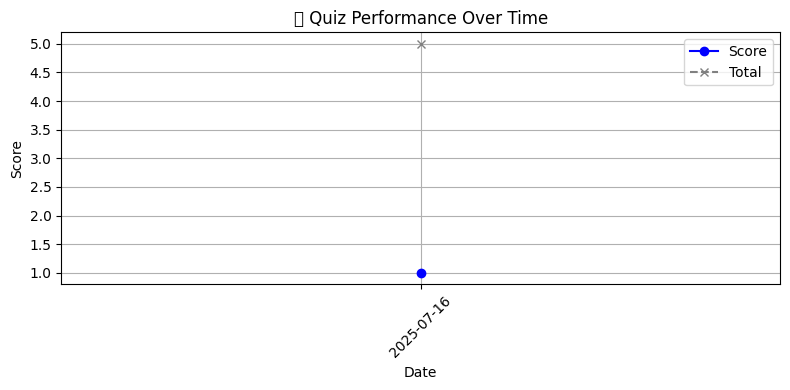


📚 Question & Answer Pairs:
1. Q: What has changed the way people communicate globally?
   A: Instant messaging, video conferencing, and social media.

2. Q: What has changed the way people communicate globally?
   A: Instant messaging, video conferencing, and social media.

3. Q: What has changed the way companies work?
   A: Technology.

4. Q: What has technology become a critical driver of productivity and innovation?
   A: In the realm of business.

5. Q: What have helped companies optimize their operations?
   A: Automated workflows, big data analytics.


🎯 Ask Questions from Your Study Notes
🔎 Your Question (or type 'exit'): what is technology can you explain neatly
💡 Answer: Technology is reshaping how education is delivered and
consumed globally. 

🔎 Your Question (or type 'exit'): exit
📈 Plotting your daily study summary progress...



/tmp/ipython-input-4-3509768476.py:158: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


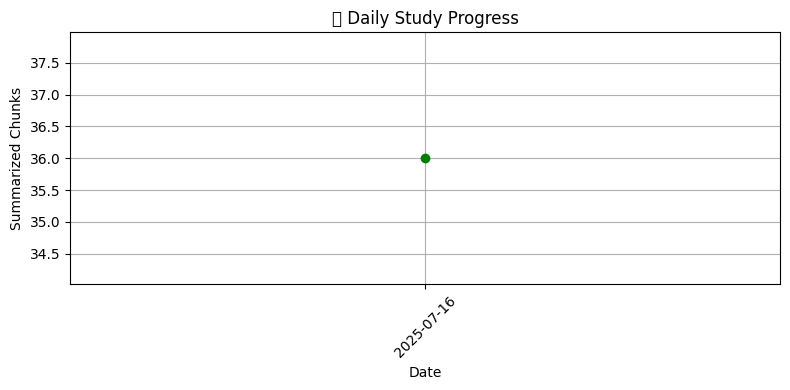

In [4]:
# 📦 Install required libraries (only run once)
!pip install pdfplumber matplotlib transformers
!pip install keybert sentence-transformers


# 📚 Imports
import pdfplumber, os, datetime, json, random
import matplotlib.pyplot as plt
from keybert import KeyBERT
from transformers import pipeline, AutoTokenizer, T5ForConditionalGeneration
from google.colab import files

# --- Load Models ---
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
qa_pipeline = pipeline("question-answering")
qg_tokenizer = AutoTokenizer.from_pretrained("valhalla/t5-small-qg-prepend")
qg_model = T5ForConditionalGeneration.from_pretrained("valhalla/t5-small-qg-prepend")

progress_file = "study_progress.json"
score_file = "quiz_scores.json"

# --- Extract Text ---
def extract_text_from_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text.strip()

# --- Summarize Text ---
def summarize_text(text):
    text = text.replace("\n", " ")
    sentences = text.split('. ')
    chunks = []
    temp = ""
    for sentence in sentences:
        temp += sentence + '. '
        if len(temp) > 900:
            chunks.append(temp.strip())
            temp = ""
    if temp:
        chunks.append(temp.strip())

    summaries, key_points = [], []
    for chunk in chunks:
        try:
            summary = summarizer(chunk)[0]['summary_text']
            summaries.append(summary)
            key_points += [pt.strip().capitalize() + '.' for pt in summary.split('.') if len(pt.strip()) > 10]
        except:
            continue
    return summaries, key_points




# --- Improved Flashcards ---
def generate_flashcards(text, n=5):
    sentences = [s.strip() for s in text.replace("\n", " ").split('.') if 20 < len(s.strip()) < 150]
    flashcards = []
    used = set()
    for _ in range(min(n, len(sentences))):
        while True:
            candidate = random.choice(sentences)
            if candidate not in used:
                used.add(candidate)
                break
        question = f"What concept or idea is described in this sentence?\n→ \"{candidate}\""
        answer = qa_pipeline(question="Summarize the meaning of this sentence.", context=candidate)['answer']
        flashcards.append((question, answer.strip().capitalize() + '.'))
    return flashcards






# --- Smarter MCQs ---
def generate_mcq(text, num_questions=5):
    sentences = [s.strip() for s in text.replace("\n", " ").split('.') if len(s.strip()) > 30]
    questions = []
    used_contexts = set()

    for _ in range(num_questions):
        while True:
            idx = random.randint(0, len(sentences) - 3)
            context = ". ".join(sentences[idx:idx + 3])
            if context not in used_contexts:
                used_contexts.add(context)
                break

        answer = qa_pipeline(question="What is this passage about?", context=context).get('answer', '').strip()
        if not answer or len(answer.split()) < 2:
            continue

        input_ids = qg_tokenizer.encode("generate question: " + context, return_tensors="pt")
        outputs = qg_model.generate(input_ids)
        question = qg_tokenizer.decode(outputs[0], skip_special_tokens=True)

        distractors = []
        tries = 0
        while len(distractors) < 3 and tries < 15:
            cand = random.choice(sentences)
            if answer.lower() not in cand.lower() and cand not in distractors:
                distractors.append(cand.strip().capitalize() + '.')
            tries += 1

        options = distractors + [answer.strip().capitalize() + '.']
        random.shuffle(options)

        questions.append({
            "question": question.strip().capitalize() + '.',
            "options": options,
            "answer": answer.strip().capitalize() + '.'
        })

    return questions

# --- QA pairs ---
def generate_qa_pairs(text, n=5):
    sentences = [s.strip() for s in text.replace("\n", " ").split('.') if len(s.strip()) > 30]
    qa_pairs = []
    for i in range(min(n, len(sentences) - 3)):
        context = ". ".join(sentences[i:i+3])
        input_ids = qg_tokenizer.encode("generate question: " + context, return_tensors="pt")
        outputs = qg_model.generate(input_ids)
        question = qg_tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = qa_pipeline(question=question, context=context)['answer'].strip()
        qa_pairs.append((question.strip().capitalize(), answer.strip().capitalize() + '.'))
    return qa_pairs

# --- Context-aware QA ---
def answer_question(context, question):
    return qa_pipeline(question=question, context=context)['answer'].strip().capitalize() + '.'

# --- Save/Plot Progress ---
def save_progress(summary_count):
    today = str(datetime.date.today())
    progress = json.load(open(progress_file)) if os.path.exists(progress_file) else {}
    progress[today] = progress.get(today, 0) + summary_count
    with open(progress_file, 'w') as f: json.dump(progress, f)

def plot_progress():
    if not os.path.exists(progress_file):
        print("No study progress recorded yet.")
        return
    with open(progress_file, 'r') as f:
        progress = json.load(f)
    plt.figure(figsize=(8, 4))
    plt.plot(progress.keys(), progress.values(), marker='o', color='green')
    plt.title("📊 Daily Study Progress")
    plt.xlabel("Date")
    plt.ylabel("Summarized Chunks")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Save/Plot Scores ---
def save_quiz_score(score, total):
    today = str(datetime.date.today())
    scores = json.load(open(score_file)) if os.path.exists(score_file) else {}
    scores[today] = {"score": score, "total": total}
    with open(score_file, 'w') as f: json.dump(scores, f)

def plot_quiz_performance():
    if not os.path.exists(score_file):
        print("No quiz scores recorded yet.")
        return
    with open(score_file, 'r') as f:
        scores = json.load(f)
    dates = list(scores.keys())
    values = [scores[d]["score"] for d in dates]
    totals = [scores[d]["total"] for d in dates]

    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', label="Score", color="blue")
    plt.plot(dates, totals, marker='x', label="Total", color="gray", linestyle='--')
    plt.title("🧪 Quiz Performance Over Time")
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---

uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
print(f"✅ File uploaded: {pdf_path}")
if os.path.exists(pdf_path) and pdf_path.lower().endswith('.pdf'):
    full_text = extract_text_from_pdf(pdf_path)
    print("\n✅ PDF text extracted.\n")

    summaries, key_points = summarize_text(full_text)
    print("📝 Summary:")
    for i, s in enumerate(summaries, 1): print(f"🔹 {i}. {s}\n")
    print("🔑 Key Points:")
    for i, kp in enumerate(key_points, 1): print(f"  • {kp}")
    save_progress(len(summaries))

    print("\n🧠 Flashcards:")
    for q, a in generate_flashcards(full_text): print(f"Q: {q}\nA: {a}\n")

    print("❓ Quiz Questions (5 MCQs):")
    mcqs = generate_mcq(full_text)
    user_answers = []
    correct_answers = []

    for i, q in enumerate(mcqs, 1):
        print(f"\n{i}. {q['question']}")
        for j, opt in enumerate(q['options']):
            print(f"   {chr(65 + j)}. {opt}")
        user_ans = input("👉 Your answer (A/B/C/D): ").strip().upper()
        user_answers.append(user_ans)
        correct_index = q['options'].index(q['answer'])
        correct_answers.append(chr(65 + correct_index))

    score = 0
    print("\n🧾 Quiz Results:")
    for i in range(len(mcqs)):
        result = "✅ Correct" if user_answers[i] == correct_answers[i] else f"❌ Incorrect (Correct: {correct_answers[i]})"
        print(f"{i+1}. Your Answer: {user_answers[i]} → {result}")
        if user_answers[i] == correct_answers[i]:
            score += 1

    print(f"\n🏁 Quiz Completed. You scored {score}/{len(mcqs)}")
    save_quiz_score(score, len(mcqs))
    print("📊 Plotting quiz performance...\n")
    plot_quiz_performance()

    print("\n📚 Question & Answer Pairs:")
    for i, (q, a) in enumerate(generate_qa_pairs(full_text), 1):
        print(f"{i}. Q: {q}\n   A: {a}\n")

    print("\n🎯 Ask Questions from Your Study Notes")
    while True:
        user_question = input("🔎 Your Question (or type 'exit'): ").strip()
        if user_question.lower() == 'exit':
            break
        print("💡 Answer:", answer_question(full_text, user_question), "\n")

    print("📈 Plotting your daily study summary progress...\n")
    plot_progress()
else:
    print("❌ Invalid PDF path. Please enter a valid path to your PDF file.")
